![logo](../../_images/cluster_generator_logo.png)

# Your First Journey With CG

![badge](https://img.shields.io/badge/Date_Created-10/26/23-cyan)

---

## Contents

- [Introduction](#Introducing-CG)
  - [Getting Started](#Getting-Started-With-The-Package)
- [Your First Cluster](#Setting-Up-Your-First-Cluster)
  - [Building the Model](#Building-The-Model)

---

## Introducing CG

So you've successfully managed to download and install the CG package into your python distribution. Congratulations! Now what?

In this guide, we're going to walk through the generation of a set of simulation initial conditions from start to finish to show you the ropes. Once you've got the hang of the basics, the examples page has many more guides exploring all of the different features CG provides.


### Getting Started With the Package

Let's start by making sure CG is properly installed. In your terminal, try

``` shell
>>> pip show cluster_generator
```

If everything goes as planned, you should see a message telling you some brief information about the project. If this appears, it means you've successfully installed the package. Now in a python IDE or terminal, you should be able to import the package as


In [1]:
import cluster_generator as cg

---

## Setting Up Your First Cluster

CG has a **lot** of ways to generate galaxy clusters, but we're going to start off slow. To build a simple cluster, we're going to provide CG with the radial profiles for $\rho_{\mathrm{gas}}$ and $\rho_{\mathrm{dyn}}$ (the total gravitating density). Once we've provided those profiles, CG will go ahead and do all the rest of the leg work to produce a beautiful galaxy cluster model.

Let's use Hernquist profiles[[1]](https://ui.adsabs.harvard.edu/abs/1990ApJ...356..359H/abstract)( (they're very simple!) for both of the density components. For reference, the equation for a Hernquist density profile is

$$ \rho(r) = \frac{M}{2\pi}\frac{r_s}{r}\frac{1}{(r+r_s)^3}.$$


If we let the cluster have a total mass of $1.2 \times 10^{15} \mathrm{M}_{\odot}$ and a scale length of $500\;\mathrm{kpc}$, we can define the total density profile as follows: 

In [2]:
total_density_profile = cg.radial_profiles.hernquist_density_profile(1.2e15, 500)

That was pretty simple wasn't it! Let's make the gas density now. If we want the gas to make up something like 10% of the mass of the cluster, then we can assign $M_{\mathrm{gas}} = 1.2\times 10^{14} \mathrm{M}_{\odot}$. Let's also try making the scale length a little shorter: 200 kpc.

In [3]:
gas_density_profile = cg.radial_profiles.hernquist_density_profile(1.2e14, 200)

Let's go ahead and take a look at what we've built so far:

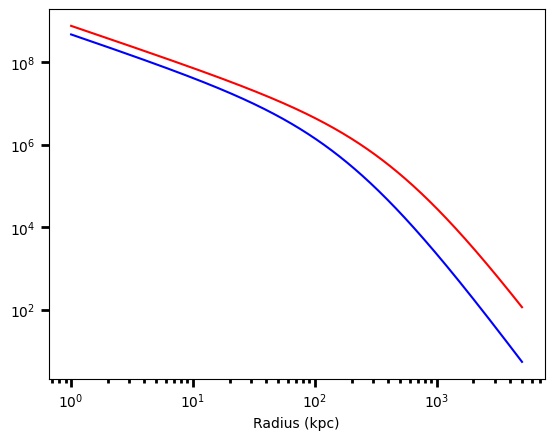

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

total_density_profile.plot(1, 5000, fig=fig, ax=ax, color="red")
gas_density_profile.plot(1, 5000, fig=fig, ax=ax, color="blue")

plt.show()

Excellent! We've built our first set of radial profiles. You're now acquainted with the first and most simple data structure in CG: the ``RadialProfile`` class, which are what these radial profiles were. They're essentially wrappers around basic python functions. Now that we've got our profiles, let's get around to building our cluster.

### Building The Model

The next step once we've chosen our profiles is to actually build the cluster. To do this, we're going to take advantage of the ``ClusterModel`` class, which will do all the math for us. 

In [5]:
galaxy_cluster_model = cg.ClusterModel.from_dens_and_tden(
    1, 10000, gas_density_profile, total_density_profile
)

cluster_generator : [INFO     ] 2023-10-27 09:50:43,933 Computing the profiles from density and total density.
cluster_generator : [INFO     ] 2023-10-27 09:50:43,939 Integrating total mass profile.
cluster_generator : [INFO     ] 2023-10-27 09:50:43,994 Integrating pressure profile.
cluster_generator : [INFO     ] 2023-10-27 09:50:45,651 Integrating gravitational potential profile.


So what just happened? We generated a ``ClusterModel`` instance which represents the cluster model from radii $1$ kpc to $10,000$ kpc. All of the output to the terminal tells us what's going on behind the scenes. It looks like first CG computed the total mass, then the gas pressure, and finally the gravitational potential.

We can do a lot with these models, but what's worth remembering is that these ``ClusterModel`` instances represent complete clusters in their own right. Each model has ``fields`` representing a variety of different pieces of data. Let's take a look at what fields are available:

In [6]:
for k, v in galaxy_cluster_model.fields.items():
    print(k, v.units)

radius kpc
density Msun/kpc**3
total_density Msun/kpc**3
total_mass Msun
gas_mass Msun
gravitational_field kpc/Myr**2
pressure Msun/(Myr**2*kpc)
temperature keV
gravitational_potential kpc**2/Myr**2
dark_matter_density Msun/kpc**3
dark_matter_mass Msun
gas_fraction dimensionless
electron_number_density cm**(-3)
entropy cm**2*keV


Each and every one of these profiles represents a different radial profile represented by discrete values. We can look more closely at some of these properties

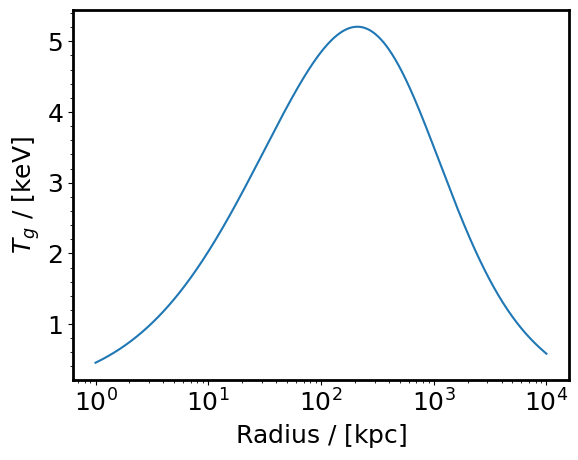

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

galaxy_cluster_model.plot("temperature", fig=fig, ax=ax)

plt.show()

We can even get a really good summary of what's going on in our cluster using the ``.panel_plot`` method:

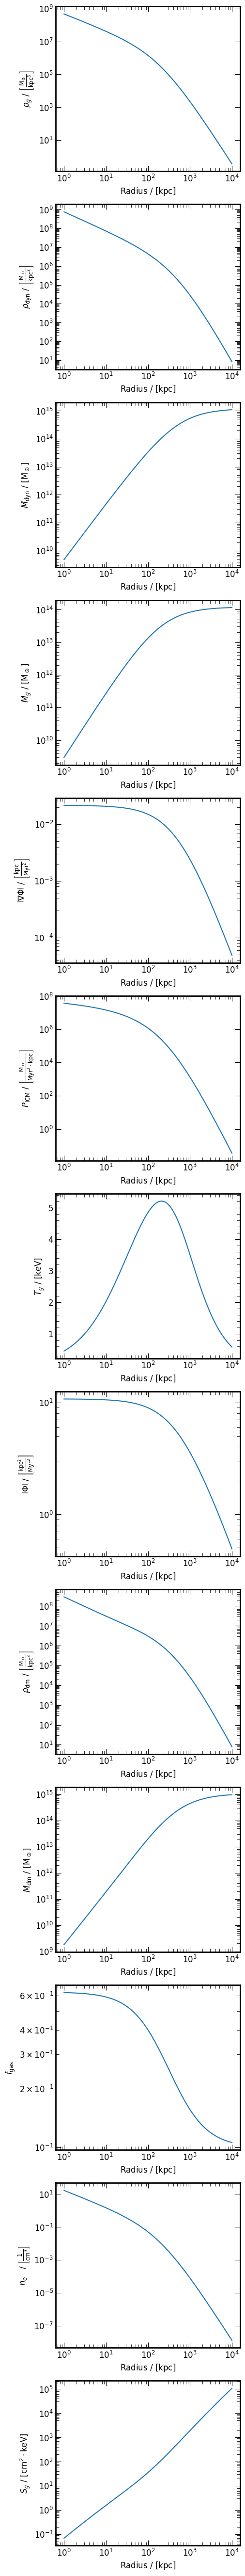

In [8]:
from cluster_generator.utils import cgparams

cgparams["plotting"]["defaults"][
    "text.usetex"
] = True  # Not necessary, just to make the plots look nice.
f, a = galaxy_cluster_model.panel_plot(base_length=3, aspect_ratio=1.2)

Now that we've generated a galaxy cluster model, we're already most of the way done with this guide! The next step is to actually build the initial conditions. For this example, we're going to just build an isolated galaxy cluster:

The first step is to save the cluster model to disk:

In [9]:
galaxy_cluster_model.write_model_to_h5("profile.h5", overwrite=True)

cluster_ic = cg.ClusterICs(
    "example_cluster",
    1,
    ["profile.h5"],
    [[0, 0, 0]],
    [[0, 0, 0]],
    num_particles={"dm": 1_000_000},
)

And now for the last major step! We can finish off by generating a set of initial conditions to our liking!

In [10]:
cg.setup_ramses_ics(cluster_ic)

Computing particle DF :   0%|          | 0/1000 [00:00<?, ?it/s]

cluster_generator : [INFO     ] 2023-10-27 09:50:53,412 We will be assigning 1000000 dark_matter particles.
cluster_generator : [INFO     ] 2023-10-27 09:50:53,413 Compute 1000000 particle positions.
cluster_generator : [INFO     ] 2023-10-27 09:50:53,755 Compute dark_matter particle velocities.


Generating particle velocities :   0%|          | 0/1000000 [00:00<?, ?it/s]

cluster_generator : [INFO     ] 2023-10-27 09:51:13,721 Simulation setups saved to Merger_Config.txt.


Now in your local directory, you should see the initialization files. Depending on which code you selected to run, these may look different; however, the general procedure is still the same. Generate the radial profiles, build the clusters, combine them into a set of ICs and output the results. Once you've got the output files ready for the simulation software of your choice, go ahead and check out the simulation guide for that software on the examples page. You'll find detailed instructions about actually performing the simulation there!